#Fastfood Nutrition EDA

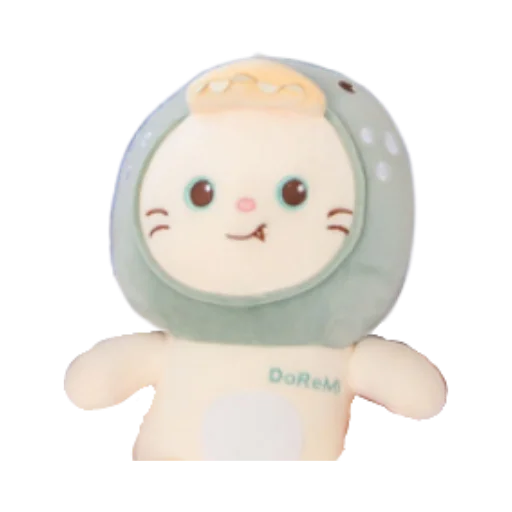

# ссылка на датасет kaggle: https://www.kaggle.com/datasets/ulrikthygepedersen/fastfood-nutrition

Датасет содержит информацию о различных блюдах из популярных сетей быстрого питания в США. В нем собрана информация о ресторанах (Mcdonalds, Taco Bell, Subway, ...), блюдах (Artisan Grilled Chicken Sandwich, Single Bacon Smokehouse Burger), калориях, калориях от содержания жира, содержание жира, насыщенного жира, транс-жиров, холестерина, натрия, углеводов, пищевых волокон, сахара, белков, витаминов А и С, кальция и является ли блюдо салатом (*спойлер: эта колонка битая).


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings

In [ ]:
sns.set_style('darkgrid') 
warnings.filterwarnings('ignore') #to hide pandas warnings

url='https://kodomo.fbb.msu.ru/~varyaaas/term4/files/fastfood.csv'
df = pd.read_csv(url)
df.head()

,restaurant,item,calories,cal_fat,total_fat,sat_fat,trans_fat,cholesterol,sodium,total_carb,fiber,sugar,protein,vit_a,vit_c,calcium,salad
0,Mcdonalds,Artisan Grilled Chicken Sandwich,380,60,7,2.0,0.0,95,1110,44,3.0,11,37.0,4.0,20.0,20.0,Other
1,Mcdonalds,Single Bacon Smokehouse Burger,840,410,45,17.0,1.5,130,1580,62,2.0,18,46.0,6.0,20.0,20.0,Other
2,Mcdonalds,Double Bacon Smokehouse Burger,1130,600,67,27.0,3.0,220,1920,63,3.0,18,70.0,10.0,20.0,50.0,Other
3,Mcdonalds,Grilled Bacon Smokehouse Chicken Sandwich,750,280,31,10.0,0.5,155,1940,62,2.0,18,55.0,6.0,25.0,20.0,Other
4,Mcdonalds,Crispy Bacon Smokehouse Chicken Sandwich,920,410,45,12.0,0.5,120,1980,81,4.0,18,46.0,6.0,20.0,20.0,Other


## Общий анализ датасета

Посмотрим на представленность различных ресторанов в датасете. 

*Для справки:*

**Taco Bell** - одна из самых популярных сетей быстрого питания в США — предлагает меню, вдохновленное традиционной мексиканской кухней. Его варианты еды включают широкий выбор тако, начос и буррито. 

**Arby's** — вторая по числу ресторанов сеть быстрого питания в США. Специализируется на продаже сэндвичей.

**Sonic** — сеть, реализующая типичный фастфуд, но отличается забавным концептом: клиенты сидят в припаркованных машинах и делают заказ по внутренней связи, а еду им приносят "официанты" (carhops)

**Dairy Queen** — это своеобразная классика фаст-фуда. В заведении очень гордятся своим мороженым, подавая самое знаменитое из них "Blizzard" в перевернутом виде, показывая качество продукта.

**Chick Fil-A** — сеть, специализирующася на продаже сэндвичей с курицей.

Наибольшее количество блюд представленно для Taco Bell, наименьшее — для Chick Fil-A. 

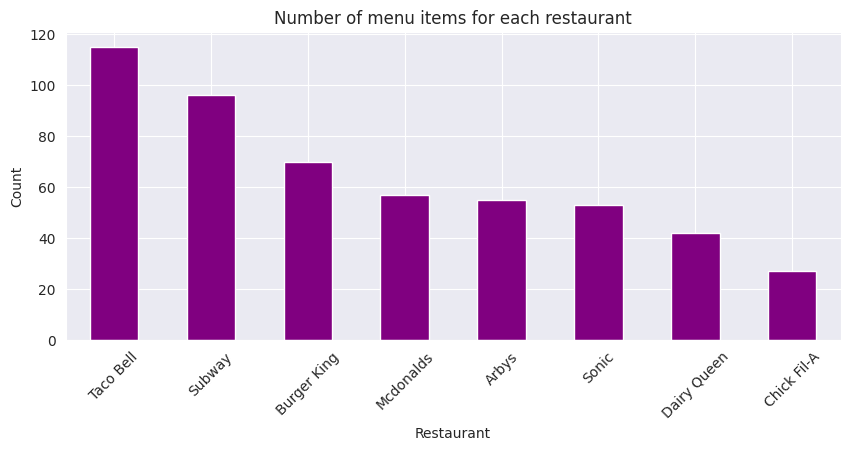

In [ ]:
plt.figure(figsize=(10, 4), dpi=100)
restaurant_category = df.restaurant.value_counts()
restaurant_category.plot.bar(color = 'purple')
plt.title('Number of menu items for each restaurant')
plt.ylabel('Count')
plt.xlabel('Restaurant')
plt.xticks(rotation=45)
plt.show()

Посмотрим на пищевую ценность десяти самых калорийных блюд в данном датасете.

Согласно рекомендациям Минздрава РФ, в среднем мужчинам требуется от 2150 до 3800 ккал/сутки, женщинам — от 1700 до 3000 ккал/сутки. 

Физиологическая потребность в жирах – от 70 до 154 г/сутки для мужчин и от 60 до 102 г/сутки для женщин.

Таким образом, можно заметить, что перечисленные блюда могут полностью покрыть суточную потребность в жирах и в среднем больше чем на половину удовлетворить суточную потребность в калориях 😲

In [ ]:
df.nlargest(n=10, columns=['calories'])[['restaurant','item','calories','total_fat']]

,restaurant,item,calories,total_fat
39,Mcdonalds,20 piece Buttermilk Crispy Chicken Tenders,2430,141
44,Mcdonalds,40 piece Chicken McNuggets,1770,107
47,Mcdonalds,10 piece Sweet N' Spicy Honey BBQ Glazed Tenders,1600,66
192,Burger King,American Brewhouse King,1550,126
38,Mcdonalds,12 piece Buttermilk Crispy Chicken Tenders,1510,88
115,Sonic,Garlic Parmesan Dunked Ultimate Chicken Sandwich,1350,100
98,Sonic,Super Sonic Bacon Double Cheeseburger (w/mayo),1280,92
270,Dairy Queen,6 Piece Chicken Strip Basket w/ Country Gravy,1260,66
211,Burger King,Rodeo King,1250,82
101,Sonic,Super Sonic Double Cheeseburger W/ Mayo,1220,87


Посмотрим на распределение калорийности блюд по ресторанам. 

Видно, что самое "адекватное" распредение для ресторана Chick Fil-A, $75$% блюд имеют калорийность менее $500$, а все блюда, представленные в датасете лежат в пределах $1000$ (у Taco Bell, кстати, тоже).

Любопытно, что для Burger King, Mcdonalds, Sonic и Subway третий квартиль примерно одинаков и равен $750$ ккал. 


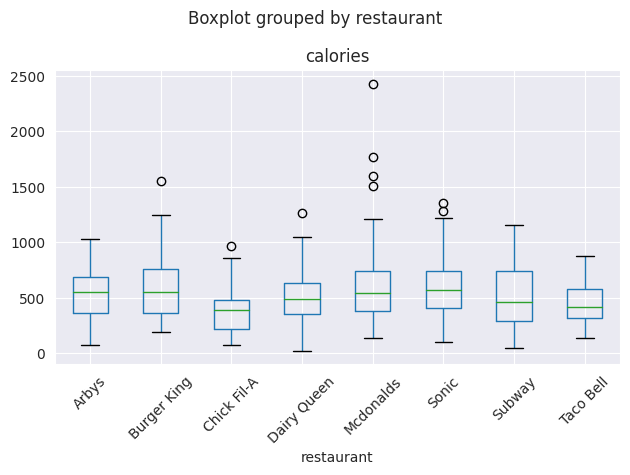

In [ ]:
df.boxplot(column='calories', by='restaurant')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Корреляция и линейная регрессия

Выдвинем гипотезу о том, что, чем жирнее пища, тем она калорийнее. 

$H_0:$ Зависимости нет

$H_1:$ Зависимость есть

Построим точечный график зависимости калорийности блюд от количества жира в нем. В нем прослеживается линейная зависимость. 

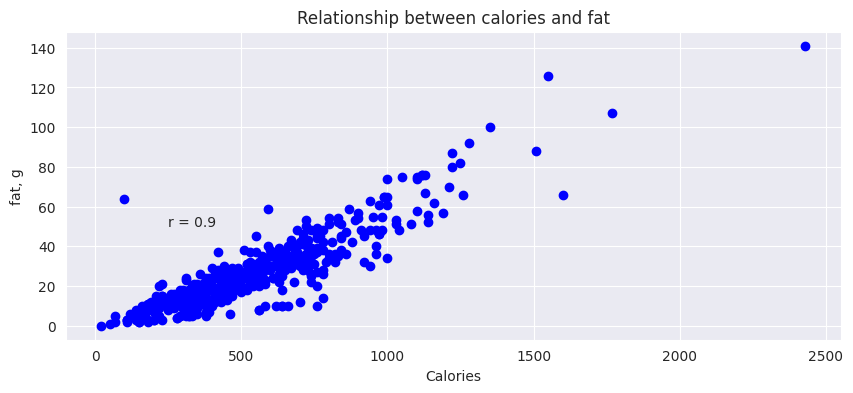

In [ ]:
correlation = df['calories'].corr(df['total_fat'], method='pearson')

plt.figure(figsize=(10, 4), dpi=100)
plt.scatter(df.calories, df.total_fat, color='blue')
plt.text(250,50,'r = {}'.format(round(correlation,2)))
plt.xlabel('Calories')
plt.ylabel('fat, g')
plt.title('Relationship between calories and fat')
plt.show()

Проверим гипотезу о зависимости на 5 процентном уровне значимости.

$p$-$value = 1.17\cdot10^{-187}$

Коэффициент Пирсона близкий к единице и маленький $p$-$value$ говорят нам о линейной зависимости, следовательно наша гипотеза об отсуствии зависимости калорийности и жирности отвергается, и верна альтернативная - зависимость есть.



In [ ]:
ss.pearsonr(df['calories'],df['total_fat']) #другой метод подсчета корреляции, который также показывает p-value

PearsonRResult(statistic=0.9004936961298489, pvalue=1.174655042626809e-187)

Построим линейную регрессию, разделив нашу выборку на train и test

Задача линейной регрессии - подобрать коэффициенты прямой $k$ и $b$ по нашей исходной размеченной выборке.

То есть наш алгоритм регрессии имеет вид $$f(x) = kx + b$$

Линейная регрессия оценена с использованием $R^2$-score:

$$R^2 = 1 - \frac{∑\limits_{i=1}^N(f(x_i) - y_i)^2}{∑\limits_{i=1}^N(y_i - \bar{y_i})^2}$$

Коэффициент принимает значения от $0$ до $1$. Чем ближе значение коэффициента к $1$, тем сильнее зависимость.

В нашем случае $R^2 = 0.86925$, еще раз подтверждая линейную зависимость

Качество линейной регрессии: r2_score=0.8692508605788695


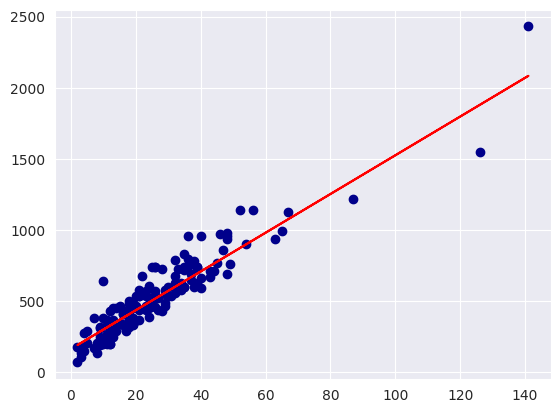

In [ ]:
X, y = np.array(df['total_fat']).reshape(-1,1), np.array(df['calories']).reshape(-1,1)
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)
LinReg = LinearRegression()
LinReg.fit(X_train, y_train)
y_pred = LinReg.predict(x_test)


print(f'Качество линейной регрессии: r2_score={r2_score(y_test, y_pred)}')

plt.scatter(x_test, y_test, color ='darkblue')
plt.plot(x_test, y_pred, color ='red')
plt.show()

Вспомнила о существовании heatmap, показывающем корреляцию между столбцами датасета.

Из нее видно, что наибольший коэффициент корреляции у количества жира и калорий из жира, что вполне обосновано. 
Интересно, что количество белка и холестерина тоже коррелируют..

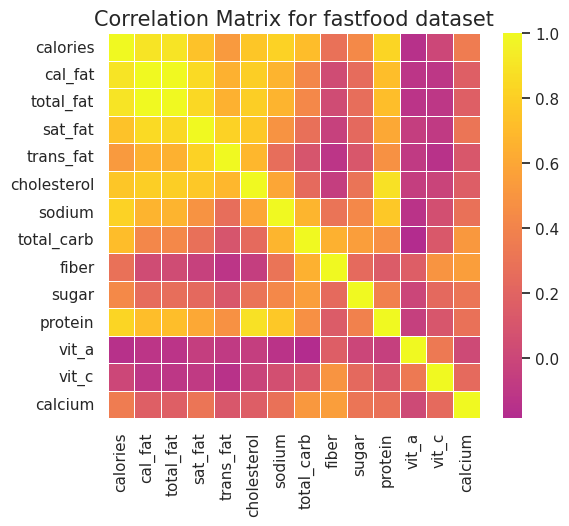

In [ ]:
plt.figure(figsize=(6, 5))
plt.title(f'Correlation Matrix for fastfood dataset', fontsize=15)
sns.heatmap(df.corr(), cmap='plasma', center=0, linewidths=.5)
plt.show()

##Добавление категориального признака и его анализ

Так как колонка Salad у датасета почему-то битая (везде категория Other), сделаем свою фильтрацию, найдя колонки содержащие слово "Salad". 

Далее я вручную посмотрела полученную табличку и убрала из салатов следующие блюда: Chicken Salad Sandwich, Pecan Chicken Salad Flatbread, Pecan Chicken Salad Sandwich (хотя судя по картинкам все эти блюда являются чем-то средним между салатом и сэндвичем)




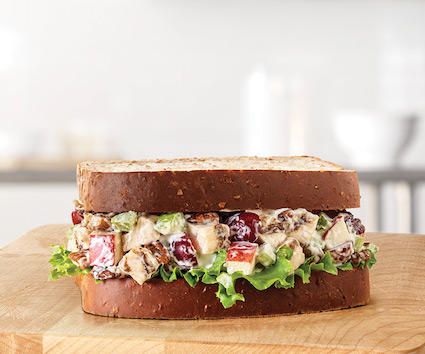

In [ ]:
sal = df[df['item'].str.contains('Salad') == True]
sal1 = sal.iloc[0:9]
sal2 = sal.iloc[12:]
salad_tab = pd.concat([sal1, sal2], axis=0)
df.loc[salad_tab['item'].index, 'salad'] = True
df.tail()

,restaurant,item,calories,cal_fat,total_fat,sat_fat,trans_fat,cholesterol,sodium,total_carb,fiber,sugar,protein,vit_a,vit_c,calcium,salad
510,Taco Bell,Spicy Triple Double Crunchwrap,780,340,38,10.0,0.5,50,1850,87,9.0,8,23.0,20.0,10.0,25.0,Other
511,Taco Bell,Express Taco Salad w/ Chips,580,260,29,9.0,1.0,60,1270,59,8.0,7,23.0,NaN,NaN,NaN,True
512,Taco Bell,Fiesta Taco Salad-Beef,780,380,42,10.0,1.0,60,1340,74,11.0,7,26.0,NaN,NaN,NaN,True
513,Taco Bell,Fiesta Taco Salad-Chicken,720,320,35,7.0,0.0,70,1260,70,8.0,8,32.0,NaN,NaN,NaN,True
514,Taco Bell,Fiesta Taco Salad-Steak,720,320,36,8.0,1.0,55,1340,70,8.0,8,28.0,NaN,NaN,NaN,True


А теперь посмотрим на сводную табличку с разделением на категории "салаты" и "другие" 

(к слову, отмечу, что в датасете представлены данные только по основым блюдам - закуски, десерты и напитки не представлены)

Можно отметить меньшую калорийность, содержание жиров и холестерина в салатах, но при этом значительно большее содержание витаминов А и С. 

In [ ]:
df.groupby('salad').mean()

,calories,cal_fat,total_fat,sat_fat,trans_fat,cholesterol,sodium,total_carb,fiber,sugar,protein,vit_a,vit_c,calcium
salad,,,,,,,,,,,,,,
True,352.459016,177.786885,19.770492,5.639344,0.147541,60.655738,931.639344,22.049180,4.442623,7.131148,22.672131,75.657895,48.552632,12.000000
Other,554.889868,247.013216,27.506608,8.491189,0.507709,74.041850,1289.074890,48.837004,4.095023,7.279736,28.593819,10.650190,16.131086,26.681648


Наглядные гистограммы распределния витаминов в салатах и остальных блюдах

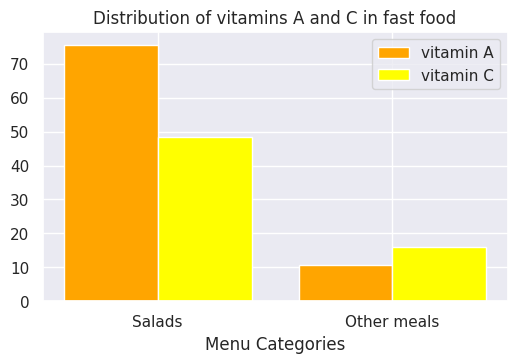

In [ ]:
plt.figure(figsize=(6, 3.5), dpi=100)

vit_a = df.groupby('salad')['vit_a'].mean()
vit_c = df.groupby('salad')['vit_c'].mean()

category = vit_c.index
vt_a = vit_a.values
vt_c = vit_c.values

X_axis = np.arange(len(category))

plt.bar(X_axis - 0.2, vt_a, 0.4, label = 'vitamin A', color = 'orange')
plt.bar(X_axis + 0.2, vt_c, 0.4, label = 'vitamin C', color = 'yellow')

plt.xticks(X_axis, ['Salads', 'Other meals'])
plt.xlabel('Menu Categories')
plt.title('Distribution of vitamins A and C in fast food')
plt.legend()
plt.show()

Распределение насыщенных и транс-жиров в салатах и остальных блюдах

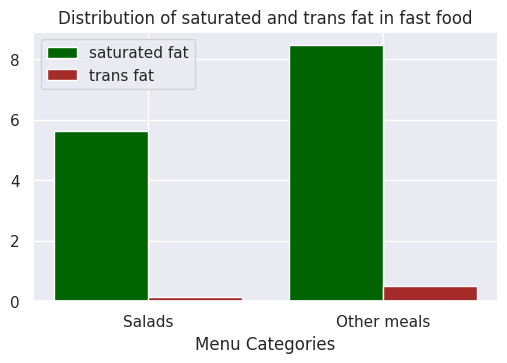

In [ ]:
plt.figure(figsize=(6, 3.5), dpi=100)
sat_fat = df.groupby('salad')['sat_fat'].mean()
trans_fat = df.groupby('salad')['trans_fat'].mean()

category = sat_fat.index
sat_f = sat_fat.values
trans_f = trans_fat.values

X_axis = np.arange(len(category))

plt.bar(X_axis - 0.2, sat_f, 0.4, label = 'saturated fat', color = 'darkgreen')
plt.bar(X_axis + 0.2, trans_f, 0.4, label = 'trans fat', color = 'brown')

plt.xticks(X_axis, ['Salads', 'Other meals'])
plt.xlabel('Menu Categories')
plt.title('Distribution of saturated and trans fat in fast food')
plt.legend()
plt.show()

Построим гистограммы распределения кальция и натрия в блюдах.

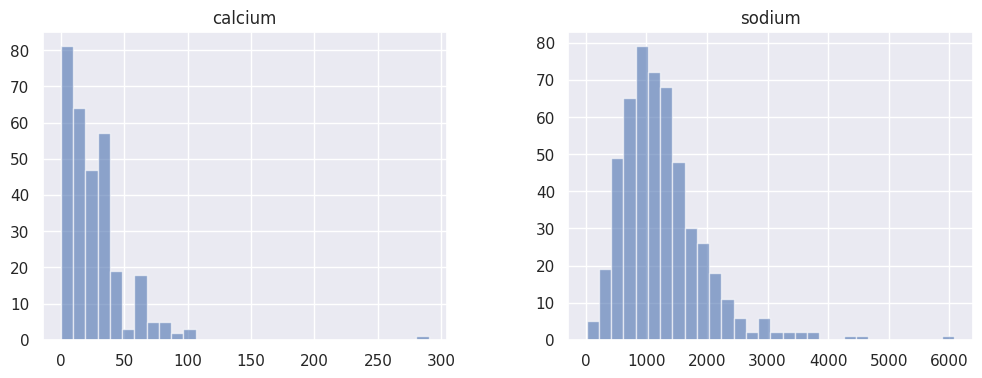

In [ ]:
df[['calcium','sodium']].hist(bins=30,figsize=(12,4), alpha=0.6)
plt.show()

Визуально гистограмма распределения натрия похожа на плотность нормального распределения 

$H_0:$ принадлежит нормальному распределению

$H_1:$ не принадлежит 

Проверим это с помощью теста Колмогорова-Смирнова. Данный тест проверяет согласуется ли выборка с заранее выбранным распределением. 

Для удобства центрируем и нормируем нашу выборку, после чего мы можем проверять ее соответствие стандартному нормальному $N(0,1)$ распределению.

$p$-$value = 0.000115$, следовательно гипотеза о нормальности отвергается


In [ ]:
sod_stand = (df['sodium'] - df['sodium'].mean())/(df['sodium'].std())
ss.kstest(sod_stand, 'norm')

KstestResult(statistic=0.0969389495795192, pvalue=0.00011542989318020063, statistic_location=0.1641589008409839, statistic_sign=1)

##Кластеризация

Попробуем кластеризовать наш датасет на три кластера, ожидая разделения еды по степени "вредности". Для начала удалим колонки с большим количеством NaN и заполним остальные NaN средним по столбцу (это уместно, так как относительно размера датасета их немного). Также удалим категориальные колонки

In [ ]:
df.isnull().sum() #NaN count

restaurant       0
item             0
calories         0
cal_fat          0
total_fat        0
sat_fat          0
trans_fat        0
cholesterol      0
sodium           0
total_carb       0
fiber           12
sugar            0
protein          1
vit_a          214
vit_c          210
calcium        210
salad            0
dtype: int64

In [ ]:
df_num = df.select_dtypes(exclude='object')

df_num.drop(columns=['vit_a','vit_c','calcium'],inplace=True)
df_num.fiber.fillna(df.fiber.mean(),inplace=True)
df_num.protein.fillna(df.protein.mean(),inplace=True)

df_num.head()

,calories,cal_fat,total_fat,sat_fat,trans_fat,cholesterol,sodium,total_carb,fiber,sugar,protein
0,380,60,7,2.0,0.0,95,1110,44,3.0,11,37.0
1,840,410,45,17.0,1.5,130,1580,62,2.0,18,46.0
2,1130,600,67,27.0,3.0,220,1920,63,3.0,18,70.0
3,750,280,31,10.0,0.5,155,1940,62,2.0,18,55.0
4,920,410,45,12.0,0.5,120,1980,81,4.0,18,46.0


Один из самых популярных методов кластеризации называется **$k$-means**. Он повсеместно используется для решения задачи кластеризации. *Алгоритм $k$ средних* является частным случаем более общего **EM-алгоритма**.

*Алгоритм:*

> Зададимся начальным приближением центров искомых кластеров $\Omega_0 = (\omega_1^0 ... \omega_k^0)$

> Пока не достигнута сходимость:
> >1. Посчитаем, каким кластерам принадлежат точки имеющегося датасета при условии текущего приближения $G_i$: $g_j^i := \arg\min\limits_{p = 1 ... k}(\rho(\Omega_p^{i-1}, x_j))$ для всех $x_j$ из датасета.

> >2. На основе посчитанного распределения датасета по кластерам $G = (g_1^i ... g_N^i )$ пересчитаем новые центры кластеров $\Omega_i = (\omega_1^i ... \omega_k^i)$.




В случае алгоритма $k$-means вообще говоря предпологается, что мы знаем это $k$ - число кластеров, но как правило оно подбирается опытным путем. 

В моем случае $k = 3$, потому что я решила разделить еду по степени вредности (не очень вредная ('good'), относительно вредная ('not that bad') и вредная ('bad'))

In [ ]:
X = StandardScaler().fit_transform(df_num)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
y_pred = kmeans.predict(X)

food_categories = {0: 'Good', 1: 'Not that bad', 2: 'Bad'}
y_pred = [food_categories[label] for label in y_pred]

df['Category'] = y_pred #adding the clasterization column to df

Видно, что в разных категориях средняя калорийность, среднее количетво жиров, холестерина и прочих элементов отличается.

In [ ]:
df.groupby('Category').mean()

,calories,cal_fat,total_fat,sat_fat,trans_fat,cholesterol,sodium,total_carb,fiber,sugar,protein,vit_a,vit_c,calcium
Category,,,,,,,,,,,,,,
Bad,1176.060606,669.030303,73.606061,24.500000,2.348485,240.606061,2207.272727,59.848485,3.103448,12.484848,68.812500,12.687500,17.352941,32.588235
Good,331.328413,137.523985,15.324723,4.592251,0.143911,42.066421,818.265683,30.619926,3.178439,4.678967,18.092251,22.748387,19.373418,14.101266
Not that bad,686.350711,301.620853,33.706161,10.170616,0.582938,85.189573,1646.824645,62.767773,5.541463,9.763033,34.270142,14.976923,21.507692,36.907692


Построим матрицу рассеивания и окрасим ее по полученным кластерам.

Видно, что почти везде особо нет четких границ кластеров, но в среднем кластер 'Good' (зеленый) везде показывает низкие значения,  'Not that bad' (оранжевый) - средние, 'Bad' (красный) - высокие.

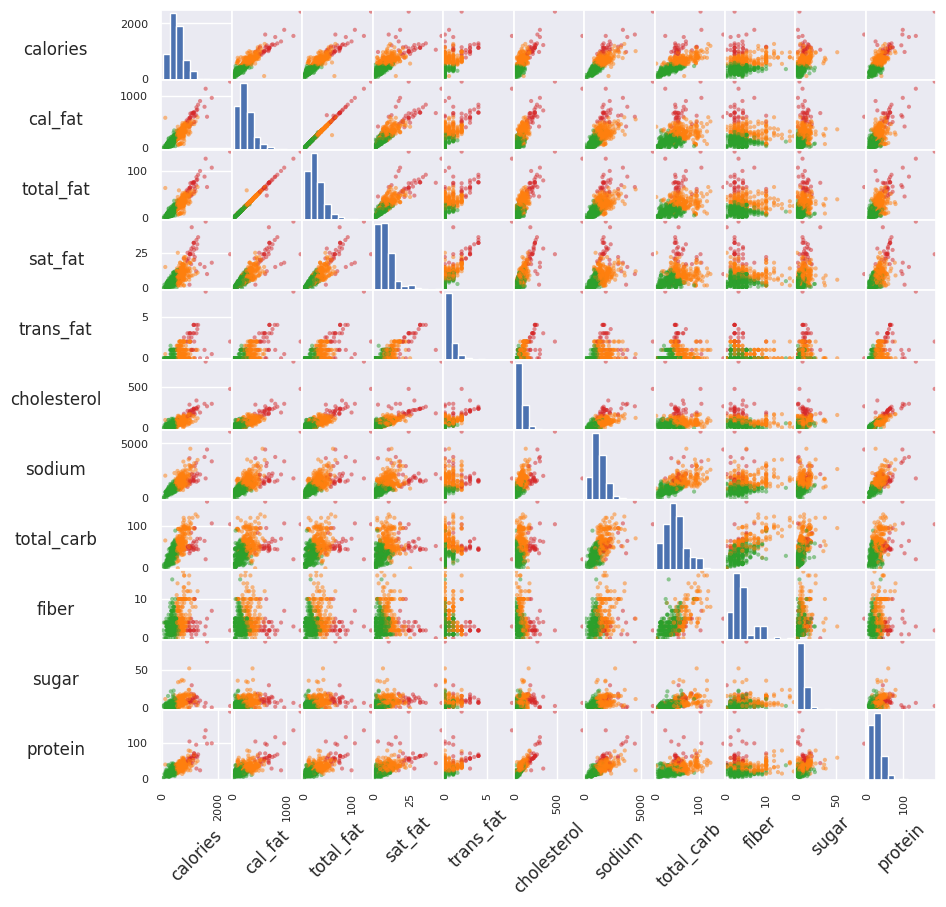

In [ ]:
colors = {'Bad':'tab:red', 'Not that bad':'tab:orange', 'Good':'tab:green'}
matrix = pd.plotting.scatter_matrix(df_num, alpha=0.5, c=df['Category'].map(colors))

[s.xaxis.label.set_rotation(45) for s in matrix.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in matrix.reshape(-1)]
[s.get_yaxis().set_label_coords(-1.5,0.3) for s in matrix.reshape(-1)]
plt.show()

В конце построим сводную таблицу по ресторанам и категориям еды.

Из таблицы видно, что БК, Макдональдс и Sonic являются лидерами по плохой еде, в то время как Taco Bell является лидером по хорошей и не содержит ни одного блюда из категории 'Bad'.

Также это хорошо видно на гистограмме, приведенной ниже.

In [ ]:
pd.crosstab(df['restaurant'], df['Category'])

Category,Bad,Good,Not that bad
restaurant,,,
Arbys,1,23,31
Burger King,13,31,26
Chick Fil-A,1,23,3
Dairy Queen,2,25,15
Mcdonalds,7,24,26
Sonic,7,24,22
Subway,2,50,44
Taco Bell,0,71,44


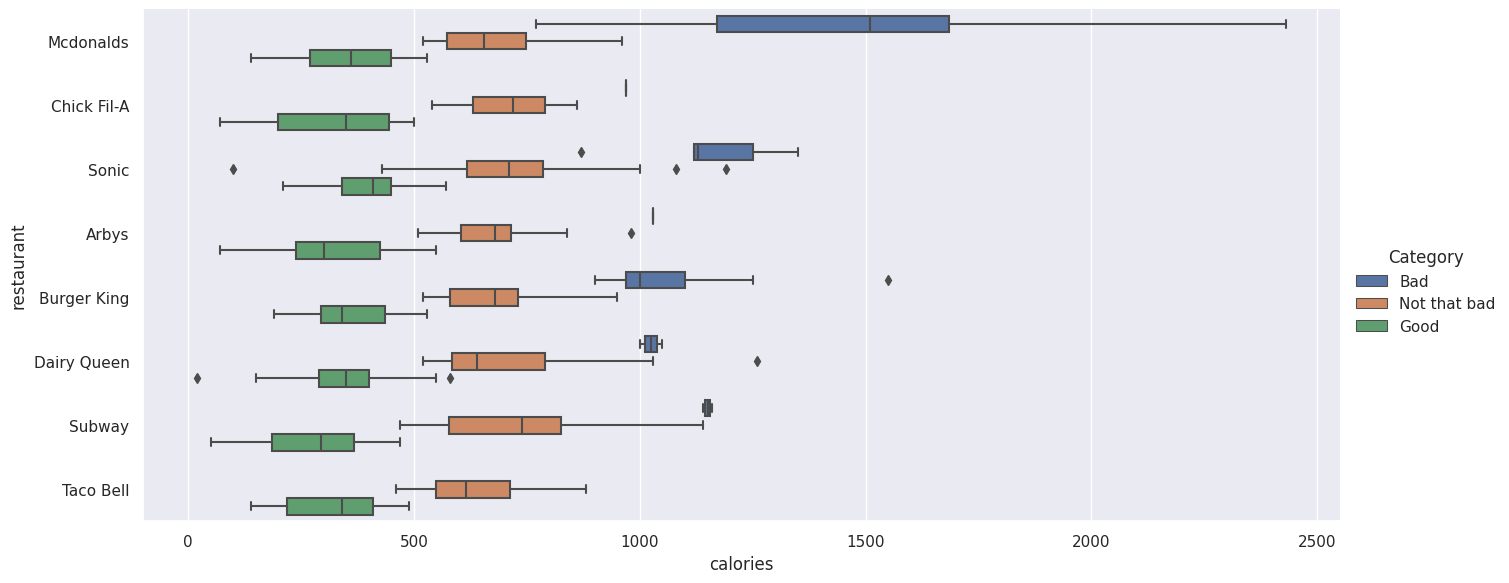

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
hue_order = ['Bad', 'Not that bad', 'Good']
sns.catplot(x='calories',
            y='restaurant', 
            hue='Category',
            kind='box', 
            data=df, height=6, aspect=2.3,
            hue_order=hue_order)
plt.show()

На этом мой небольшой анализ данных завершен.

**Выводы:**

1) Чем калорийнее блюдо, тем выше в нем содержание жиров ($\alpha = 0.05$).

2) Количество кальция в блюдах не имеет нормальное распределение ($\alpha = 0.
05$).

3) Построена линейная регрессия для определения количества жира по калорийности (или наоборот)

4) Еда датасета была кластеризована на три кластера: "полезная", "средне вредная", "вредная"

5) Ресторан Taco Bell вляется лидером по "полезной" еде. Еда в БК, Макдональдс и Sonic в основном вредная или средне вредная. 

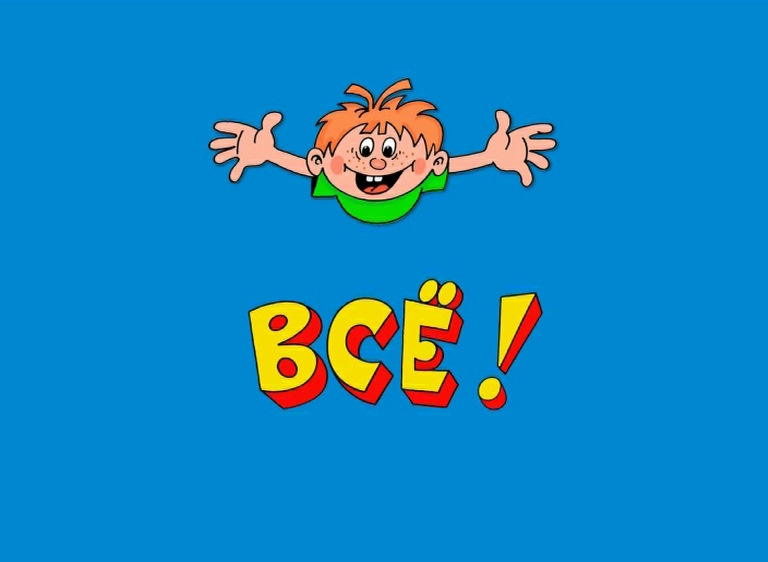